In [102]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%reload_ext autoreload
%autoreload 2

# <span style='color:lightgreen'>Logs

In [118]:
model_id = 'USC_32_32'
lt_logs_df = pd.read_csv('./logs/long_term_forecast.csv', index_col = 0)
start_index = 220
query = (lt_logs_df['model_id'] == model_id)&(lt_logs_df['fde'].isna() == False)&(lt_logs_df.index >= start_index)
lt_logs_df[query][['model','consider_only_offense','features','input_features','seq_len', 'pred_len','e_layers','d_model', 'd_layers', 'd_ff',
       'dropout', 'learning_rate', 'train_epochs','nb_params', 'fde','rmse', 'mae']].sort_values('fde')#.head(20)

,model,consider_only_offense,features,input_features,seq_len,pred_len,e_layers,d_model,d_layers,d_ff,dropout,learning_rate,train_epochs,nb_params,fde,rmse,mae
223,Transformer,True,MS,A,32,32,2,256,1,1024,0.1,0.001,36,5280769,2.926098,1.706686,1.093945
221,LSTM,True,MS,A,32,32,2,256,1,1024,0.1,0.001,36,853249,3.033806,1.806024,1.166339
224,DLinear,True,S,A,32,32,2,256,1,1024,0.1,0.001,36,2112,3.036681,1.708961,1.034564
222,Transformer,True,S,A,32,32,2,256,1,1024,0.1,0.001,36,5234689,3.081521,1.769631,1.099922
228,PatchTST,True,S,A,32,32,2,256,1,1024,0.1,0.001,36,2897441,3.094815,1.791954,1.099074
220,LSTM,True,S,A,32,32,2,256,1,1024,0.1,0.001,36,791809,3.168699,1.853354,1.165634
226,iTransformer,True,S,A,32,32,2,256,1,1024,0.1,0.001,36,1596704,3.194651,1.853162,1.119300
227,iTransformer,True,MS,A,32,32,2,256,1,1024,0.1,0.001,36,1596704,3.866801,2.436459,1.466493
225,DLinear,True,MS,A,32,32,2,256,1,1024,0.1,0.001,36,2112,3.882972,2.442303,1.463488
229,PatchTST,True,MS,A,32,32,2,256,1,1024,0.1,0.001,36,2897441,3.885926,2.445549,1.470205


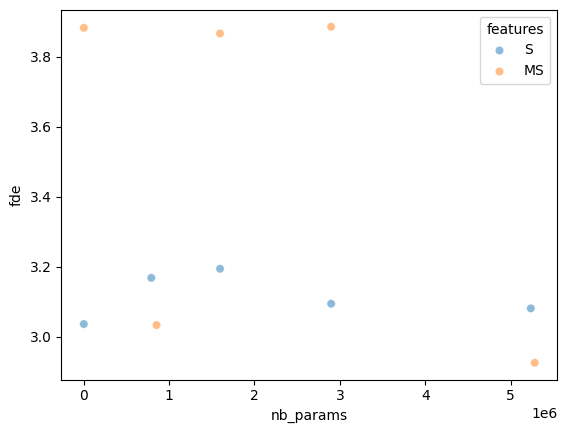

In [119]:
sns.scatterplot( data = lt_logs_df[query], 
                x = 'nb_params', y='fde', alpha = 0.5,
                hue= 'features');

### Scoring baselines

In [110]:
from types import SimpleNamespace
from data_provider.data_factory import data_provider

usc_args = SimpleNamespace(**lt_logs_df.loc[207].to_dict())
usc_args.scale = False
uscds, uscdl = data_provider(args= usc_args, flag = 'test', )
uscds.data_x.shape, uscds.data_y.shape

test 4233


((4233, 32, 1), (4233, 32, 1))

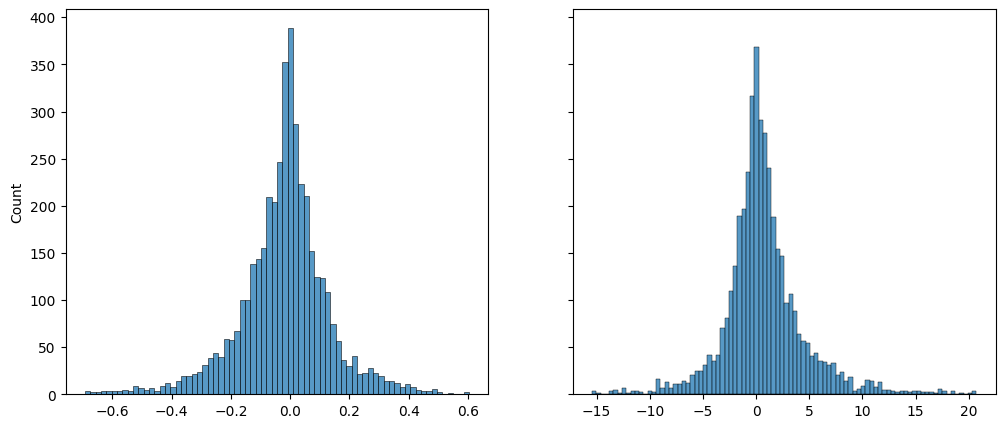

In [111]:
tmp = uscds.data_x[:,-1,0] -  uscds.data_y[:,0,0]
fig, axs = plt.subplots(1,2,figsize = (12,5), sharey=True)
sns.histplot(tmp, ax = axs[0]);
sns.histplot(uscds.data_y[:,-1,0], ax = axs[1]);


In [112]:
uscds.data_x[0,-5:,0] , uscds.data_y[0,:5,0]

(array([-0.5815458 , -0.4777832 , -0.3362279 , -0.13446379,  0.        ],
       dtype=float32),
 array([0.17934847, 0.41184092, 0.6160221 , 0.8721256 , 1.0302544 ],
       dtype=float32))

In [114]:
x,y = uscds.data_x, uscds.data_y

In [115]:
ind = 0
x[ind,-5:,0], y[ind,usc_args.label_len:usc_args.label_len+5,0]

(array([-0.5815458 , -0.4777832 , -0.3362279 , -0.13446379,  0.        ],
       dtype=float32),
 array([2.177392 , 2.1703014, 2.1655731, 2.1820927, 2.18682  ],
       dtype=float32))

In [124]:
ss_fde = np.sqrt(np.mean(uscds.data_y[:,-1,0]**2))
ss_rmse = np.sqrt(np.mean(uscds.data_y[:,:,0]**2))
ss_fde, ss_rmse

(3.8998787, 2.452531)

In [141]:
bl_cv_delta = uscds.data_x[:,-1,0] - uscds.data_x[:,-2,0]
bl_cv_pred = np.repeat(uscds.data_x[:,-1,0].reshape(-1,1,1), y.shape[1], axis=1)
for i in range(y.shape[1]):
    bl_cv_pred[:,i,0] = (i+1) * bl_cv_delta 
cv_fde = np.sqrt(np.mean( (uscds.data_y[:,-1,0] - bl_cv_pred[:,-1,0])**2 ))
cv_rmse = np.sqrt(np.mean( (uscds.data_y[:,:,0] - bl_cv_pred[:,:,0])**2 ))
cv_fde, cv_rmse

(3.9323, 2.0943015)

In [143]:
bls = [{'model':'Baseline - StandStill', 'features':'S','fde':ss_fde, 'rmse':ss_rmse},
       {'model':'Baseline - ConstantVelocity', 'features':'S','fde':cv_fde, 'rmse': cv_rmse}]

### Comparison

In [145]:
comp = pd.concat([lt_logs_df[query][['model','features','fde','rmse']], pd.DataFrame(bls)]).reset_index(drop=True)
comp.sort_values(by = 'fde').round(3)

,model,features,fde,rmse
3,Transformer,MS,2.926,1.707
1,LSTM,MS,3.034,1.806
4,DLinear,S,3.037,1.709
2,Transformer,S,3.082,1.770
8,PatchTST,S,3.095,1.792
0,LSTM,S,3.169,1.853
6,iTransformer,S,3.195,1.853
7,iTransformer,MS,3.867,2.436
5,DLinear,MS,3.883,2.442
9,PatchTST,MS,3.886,2.446


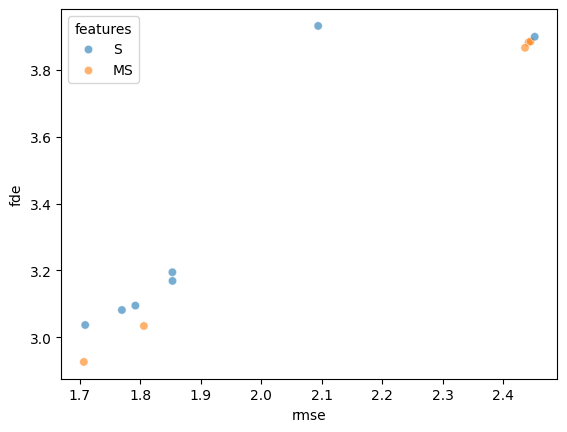

In [147]:
sns.scatterplot(data=comp, x = 'rmse', y = 'fde', hue = 'features', alpha = 0.6);